In [1]:
%pip install nltk --upgrade


[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import requests
from pprint import pprint
import datetime

In [14]:
# define which game to scrape
#appid = 24780  # simcity4
appid = 2357570 # over watch 2

# set base name for the file
#base_name = 'simcity4'
base_name = 'overwatch2'

scrape_file = f'reviews_{base_name}.csv'
results_file = f'results_{base_name}.csv'
extended_file = f'reviews_{base_name}_extended.csv'


In [15]:

# Open a file to write the scraped data
with open(scrape_file, "w+", encoding='utf-8') as fo:
    # Write the header for the CSV file
    print("review,author_vote,other_votes,weighted_vote_score,votes_funny,comment_count,timestamp_created,playtime_at_review", file=fo)

    cursor = '*'  # Start with the initial cursor
    base_url = f'https://store.steampowered.com/appreviews/{appid}'

    curr_page = 0 # Initialize the current page counter
    while True:
        # Set the parameters for the API request
        params = { # https://partner.steamgames.com/doc/store/getreviews
            'json' : 1,
            'filter' : 'all', # sort by: recent, updated, all (helpfulness)
            'language' : 'english', # https://partner.steamgames.com/doc/store/localization # Only fetch reviews in English
            'day_range' : 9223372036854775807, # shows reviews from all time 
            'review_type' : 'all', # include all reviews (positive and negative)
            'purchase_type' : 'all', # all, non_steam_purchase, steam
            'num_per_page' : 100, # Number of reviews per page
            'cursor': cursor,  # Use the cursor returned from the last request
        }
        response = requests.get(base_url, params=params) #Make the API request
        data = response.json() # Parse the JSON response

        print(curr_page, end=" ") # Print the current page number
        curr_page += 1 # Increment the current page counter

        # Break the loop if there are no more reviews
        if 'reviews' in data and not data['reviews']:
            break
        
        page_list = data['reviews'] # Get the list of reviews from the response

        for i, page in enumerate(page_list):
            words =  page["review"].split() # Split the review text into words

            if len(words) < 30: 
                continue # Skip reviews with less than 30 words
            
            # Prepare the review text for CSV
            rev = '"' + page["review"].replace('"',"") + '"'
            author_vote = 1 if page['voted_up'] else 0 # Convert voted_up to binary
            other_votes = page['votes_up']
            weighted_vote_score = page["weighted_vote_score"] 
            votes_funny = page["votes_funny"] # Get votes_funny or default to 0
            comment_count = page["comment_count"] # Get comment_count or default to 0
            timestamp_created = datetime.datetime.fromtimestamp(page["timestamp_created"]).strftime('%Y-%m-%d %H:%M:%S') # Convert timestamp to human-readable format
            playtime_at_review = page["author"].get("playtime_at_review", 0) #Get playtime_at_review or default to 0

            # Write the extracted data to the CSV file
            print(rev, ',', author_vote, ',', other_votes, ',', weighted_vote_score, ',', votes_funny, ',', comment_count, ',', timestamp_created, ',', playtime_at_review, file=fo)

        # Update the cursor for the next API request
        cursor = data['cursor']

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

KeyboardInterrupt: 

In [5]:
# Using the SentiWordNet lexicon
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import pandas as pd

# Download the SentiWordNet and WordNet resources
nltk.download('sentiwordnet');
nltk.download('wordnet');
nltk.download('averaged_perceptron_tagger');
nltk.download('punkt');

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/karakaya/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/karakaya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/karakaya/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/karakaya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
def get_sentiment(word, pos):
    synsets = list(swn.senti_synsets(word, pos))
    if not synsets:
        return 0, 0, 0
    synset = synsets[0]
    return synset.pos_score(), synset.neg_score(), synset.obj_score()

def sentiment_analysis_SentiWordNet(sentence):
    tokens = nltk.word_tokenize(sentence)
    pos_tags = nltk.pos_tag(tokens)
    sentiment_scores = {'positive': 0, 'negative': 0, 'objective': 0 }
    word_count = 0
    adj_count = 0
    verb_count = 0
    noun_count = 0
    adv_count = 0

    for word, tag in pos_tags:
        wn_tag = get_wordnet_pos(tag)

        if wn_tag is not None:
            #print(f"{word}={wn_tag}", end=", ")
            pos_score, neg_score, obj_score = get_sentiment(word, wn_tag)
            sentiment_scores['positive'] += pos_score
            sentiment_scores['negative'] += neg_score
            sentiment_scores['objective'] += obj_score
            word_count += 1
            adj_count += 1
            verb_count += 1
            noun_count += 1
            adv_count += 1

    # Normalize the score by the number of words
    if word_count > 0:
        sentiment_scores['positive'] /= word_count
        sentiment_scores['negative'] /= word_count
        sentiment_scores['objective'] /= word_count
    print(".", end="")
    return sentiment_scores['positive'], sentiment_scores['negative'], sentiment_scores['objective'], word_count, adj_count, verb_count, noun_count, adv_count

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return None

In [28]:
# Read the scraped CSV file
df = pd.read_csv(scrape_file, encoding='utf-8'  )
display(df)

,review,author_vote,other_votes,weighted_vote_score,votes_funny,comment_count,timestamp_created,playtime_at_review
0,"Alright, let's actually provide a constructive...",0,11188,0.979914,205,0,2023-08-21 13:16:50,17
1,"Alright, let's actually provide a constructive...",0,7901,0.972368,130,88,2024-01-27 00:05:18,7
2,"Alright, let's actually provide a constructive...",0,4958,0.971370,76,88,2023-12-26 23:22:02,13
3,Imagine you bought a book and its great.\nfew ...,0,3231,0.970030,194,0,2024-02-08 13:39:54,2772
4,[i][b]What we’re hoping to do with Overwatch 2...,0,1199,0.966784,28,58,2023-08-10 14:14:46,17
...,...,...,...,...,...,...,...,...
13245,The stupid SMS verification effectively c*ckbl...,0,0,0.000000,0,0,2024-03-07 16:03:57,14
13246,"Still fun to play with friends, boy this the m...",0,0,0.000000,0,0,2024-03-07 02:13:48,2957
13247,I've been playing since the end of 2018 and I ...,0,0,0.000000,0,0,2024-03-06 14:29:21,549
13248,"The matchmaking is horrible, it seems that a k...",0,0,0.000000,0,0,2024-03-06 13:38:16,58


In [29]:
# Perform sentiment analysis on each review
results = []

reviews = df['review'].tolist()

for review in reviews:
    pos_score, neg_score, obj_score, word_count, adj_count, verb_count, noun_count, adv_count = sentiment_analysis_SentiWordNet(review)
    results.append({
        'review': review,
        'positive_score': pos_score,
        'negative_score': neg_score,
        'objective_score': obj_score,
        'word_count': word_count,
        'adj_count': adj_count,
        'verb_count': verb_count,
        'noun_count': noun_count,
        'adv_count': adv_count,
    })
    
# Convert the results to a DataFrame for better readability
results_df = pd.DataFrame(results)

# Save the results to a CSV file incase the concat does not work
results_df.to_csv(results_file, index=False)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [30]:
# Perform descriptive statistics, using the describe() method from pandas to compute descriptive statistics (mean, standard deviation, min, max, etc.) for the sentiment scores and word count.
#descriptive_stats = results_df.describe()
#print(descriptive_stats)

# Perform descriptive statistics on the combined DataFrame
#descriptive_stats = combined_df.describe(include='all')
#print(descriptive_stats)

# read in file so it's independent from the previous cells
results_df = pd.read_csv(results_file)

# Combine the original DataFrame with the sentiment analysis results
combined_df = pd.concat([df, results_df.drop(columns='review')], axis=1)

# Print the combined DataFrame
# print(combined_df)

# Perform descriptive statistics on the combined DataFrame
# descriptive_stats = combined_df.describe(include='all')
# print(descriptive_stats)

In [31]:
display(combined_df)

,review,author_vote,other_votes,weighted_vote_score,votes_funny,comment_count,timestamp_created,playtime_at_review,positive_score,negative_score,objective_score,word_count,adj_count,verb_count,noun_count,adv_count
0,"Alright, let's actually provide a constructive...",0,11188,0.979914,205,0,2023-08-21 13:16:50,17,0.065798,0.046319,0.749233,815,815,815,815,815
1,"Alright, let's actually provide a constructive...",0,7901,0.972368,130,88,2024-01-27 00:05:18,7,0.065798,0.046319,0.749233,815,815,815,815,815
2,"Alright, let's actually provide a constructive...",0,4958,0.971370,76,88,2023-12-26 23:22:02,13,0.065798,0.046319,0.749233,815,815,815,815,815
3,Imagine you bought a book and its great.\nfew ...,0,3231,0.970030,194,0,2024-02-08 13:39:54,2772,0.060606,0.022727,0.825758,33,33,33,33,33
4,[i][b]What we’re hoping to do with Overwatch 2...,0,1199,0.966784,28,58,2023-08-10 14:14:46,17,0.058088,0.028822,0.524678,466,466,466,466,466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13245,The stupid SMS verification effectively c*ckbl...,0,0,0.000000,0,0,2024-03-07 16:03:57,14,0.053571,0.107143,0.744048,21,21,21,21,21
13246,"Still fun to play with friends, boy this the m...",0,0,0.000000,0,0,2024-03-07 02:13:48,2957,0.050781,0.093750,0.667969,32,32,32,32,32
13247,I've been playing since the end of 2018 and I ...,0,0,0.000000,0,0,2024-03-06 14:29:21,549,0.058128,0.042695,0.705761,243,243,243,243,243
13248,"The matchmaking is horrible, it seems that a k...",0,0,0.000000,0,0,2024-03-06 13:38:16,58,0.070988,0.037037,0.608025,81,81,81,81,81


In [32]:
# write combined data to a new file
# this is so we can load the data back in later without having to re-compute the sentiment analysis
combined_df.to_csv(extended_file, index=False, encoding='utf-8')

In [33]:
# Load the CSV file'
df = pd.read_csv(extended_file)

# Display the first few rows of the dataset
print(df.head())

# Display basic information about the dataset
print(df.info())

# Display summary statistics of the dataset
print(df.describe(include='all'))

                                              review  author_vote  \
0  Alright, let's actually provide a constructive...            0   
1  Alright, let's actually provide a constructive...            0   
2  Alright, let's actually provide a constructive...            0   
3  Imagine you bought a book and its great.\nfew ...            0   
4  [i][b]What we’re hoping to do with Overwatch 2...            0   

   other_votes  weighted_vote_score  votes_funny  comment_count  \
0        11188             0.979914          205              0   
1         7901             0.972368          130             88   
2         4958             0.971370           76             88   
3         3231             0.970030          194              0   
4         1199             0.966784           28             58   

       timestamp_created  playtime_at_review  positive_score  negative_score  \
0   2023-08-21 13:16:50                   17        0.065798        0.046319   
1   2024-01-27 00:05:1

In [34]:
# Check for missing values
print(df.isnull().sum())

review                 0
author_vote            0
other_votes            0
weighted_vote_score    0
votes_funny            0
comment_count          0
timestamp_created      0
playtime_at_review     0
positive_score         0
negative_score         0
objective_score        0
word_count             0
adj_count              0
verb_count             0
noun_count             0
adv_count              0
dtype: int64


In [35]:
# Display the data types of each column
print(df.dtypes)

review                  object
author_vote              int64
other_votes              int64
weighted_vote_score    float64
votes_funny              int64
comment_count            int64
timestamp_created       object
playtime_at_review       int64
positive_score         float64
negative_score         float64
objective_score        float64
word_count               int64
adj_count                int64
verb_count               int64
noun_count               int64
adv_count                int64
dtype: object


In [36]:
# CH aggregate means of values over time (monthly)
df_agg  = df.copy() 
df_agg['timestamp_created'] = pd.to_datetime(df_agg['timestamp_created']) # make python datetime object
df_agg.set_index('timestamp_created', inplace=True) # set index to timestamp_created

# drop review column as it is not numeric
df_agg.drop(columns=['review'], inplace=True)

# resample all numeric columns to monthly
#df_agg = df_agg.resample('MS').mean() # resample all numeric columns to monthly

# resample all numeric columns to 3 month
df_agg = df_agg.resample('3MS').mean() # resample all numeric columns to 6 month

# resample all numeric columns to 6 month
#df_agg = df_agg.resample('6MS').mean() # resample all numeric columns to 6 month

df_agg.reset_index(inplace=True) # reset index to make timestamp_created a column again
df_agg['timestamp_created'] = df_agg['timestamp_created'].dt.strftime('%Y-%m') # format timestamp_created
display(df_agg)



,timestamp_created,author_vote,other_votes,weighted_vote_score,votes_funny,comment_count,playtime_at_review,positive_score,negative_score,objective_score,word_count,adj_count,verb_count,noun_count,adv_count
0,2023-08,0.216699,28.294314,0.519508,2.982701,0.424519,533.163764,0.069725,0.053238,0.663127,97.502595,97.502595,97.502595,97.502595,97.502595
1,2023-11,0.327175,26.607390,0.508142,1.475751,0.444188,3115.488838,0.073478,0.054998,0.680151,70.696690,70.696690,70.696690,70.696690,70.696690
2,2024-02,0.283284,15.673314,0.363212,2.581232,0.129032,4102.466862,0.070232,0.057641,0.681608,77.445161,77.445161,77.445161,77.445161,77.445161
3,2024-05,0.231111,8.150476,0.280056,1.191746,0.126349,5006.064127,0.068214,0.058914,0.686773,71.152381,71.152381,71.152381,71.152381,71.152381


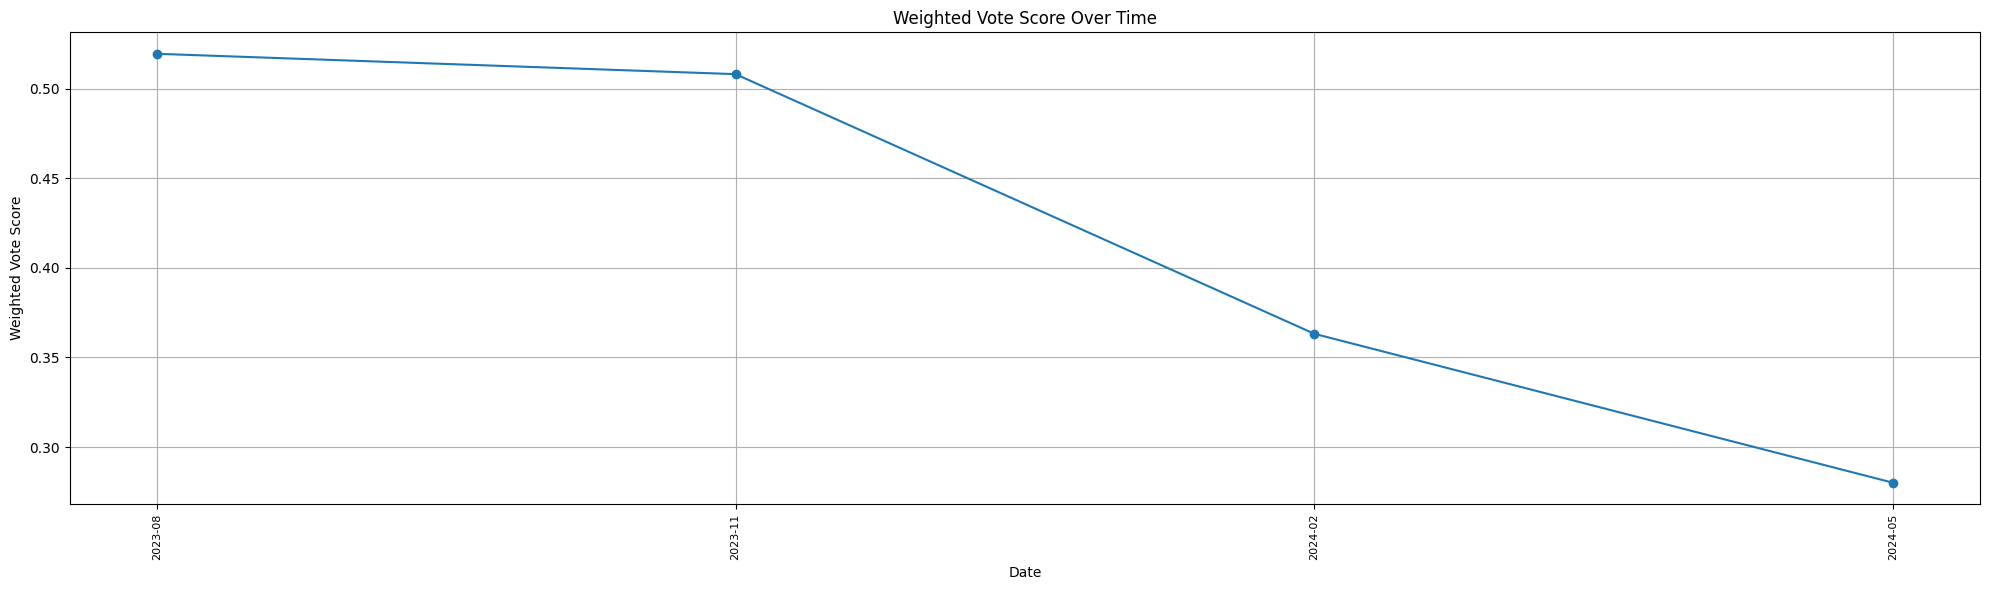

In [42]:
# plot weighted_vote_score over time
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(df_agg['timestamp_created'], df_agg['weighted_vote_score'], marker='o')
plt.title('Weighted Vote Score Over Time')
plt.xlabel('Date')
plt.ylabel('Weighted Vote Score')
plt.xticks(fontsize=8)
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()


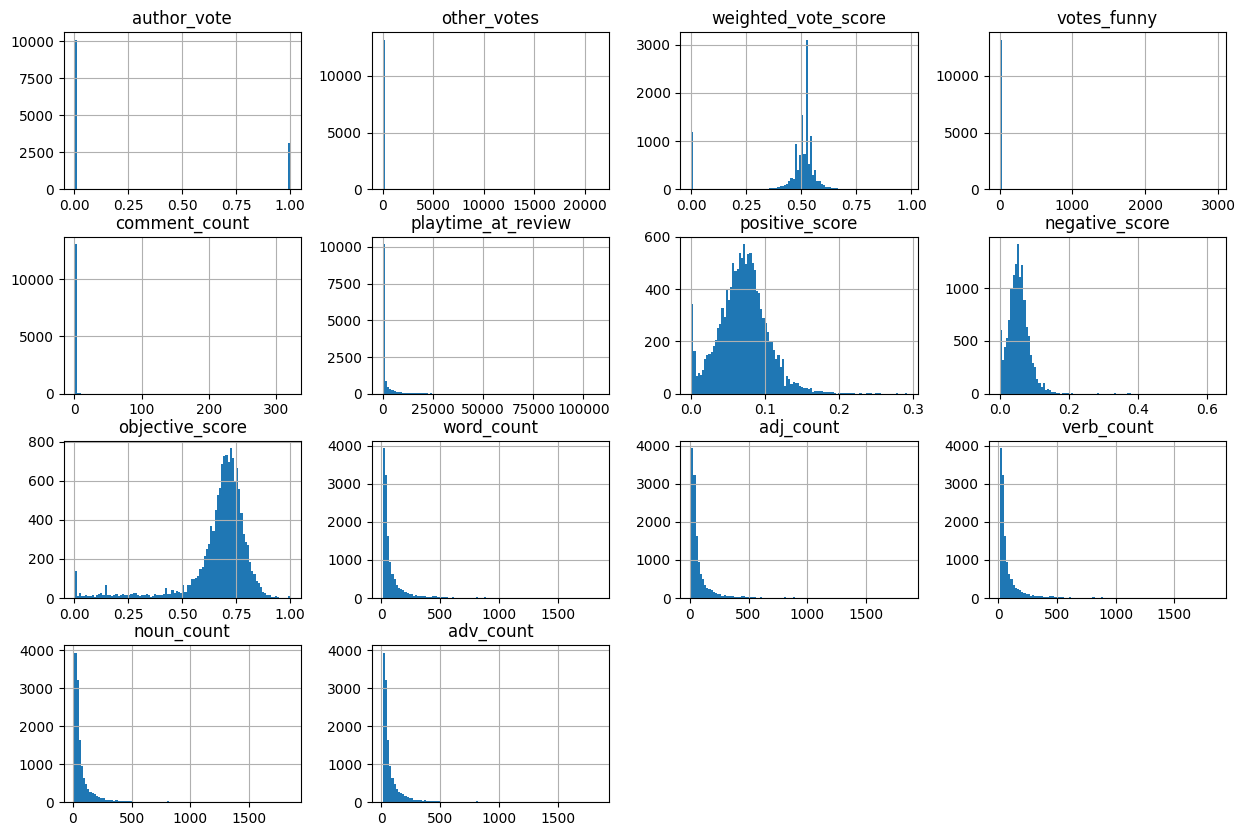

In [41]:
# Distribution of Numerical Variables
# Visualize the distribution of numerical variables using histograms and boxplots.
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for numerical columns
df.hist(bins=100, figsize=(15, 10))
plt.show()

# Boxplot for numerical columns
#plt.figure(figsize=(15, 10))
#sns.boxplot(data=df)
#plt.xticks(rotation=90)
#plt.show()

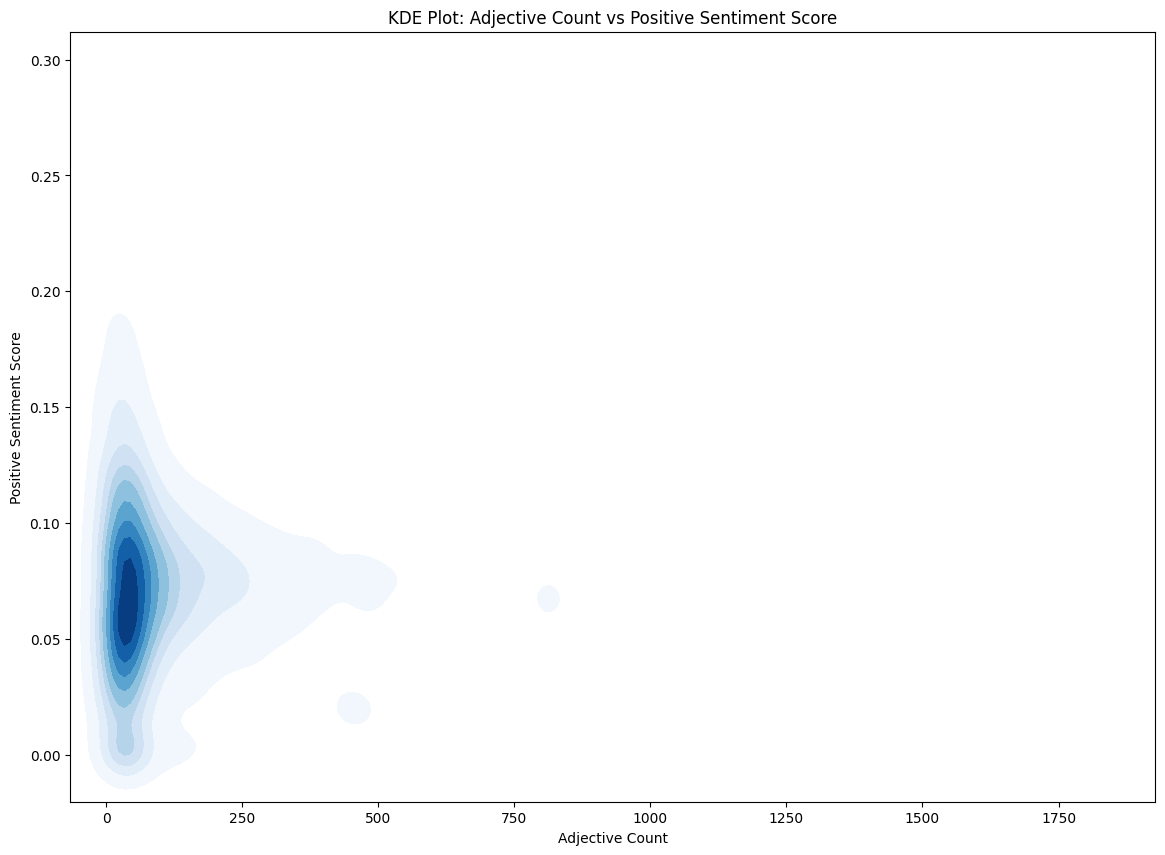

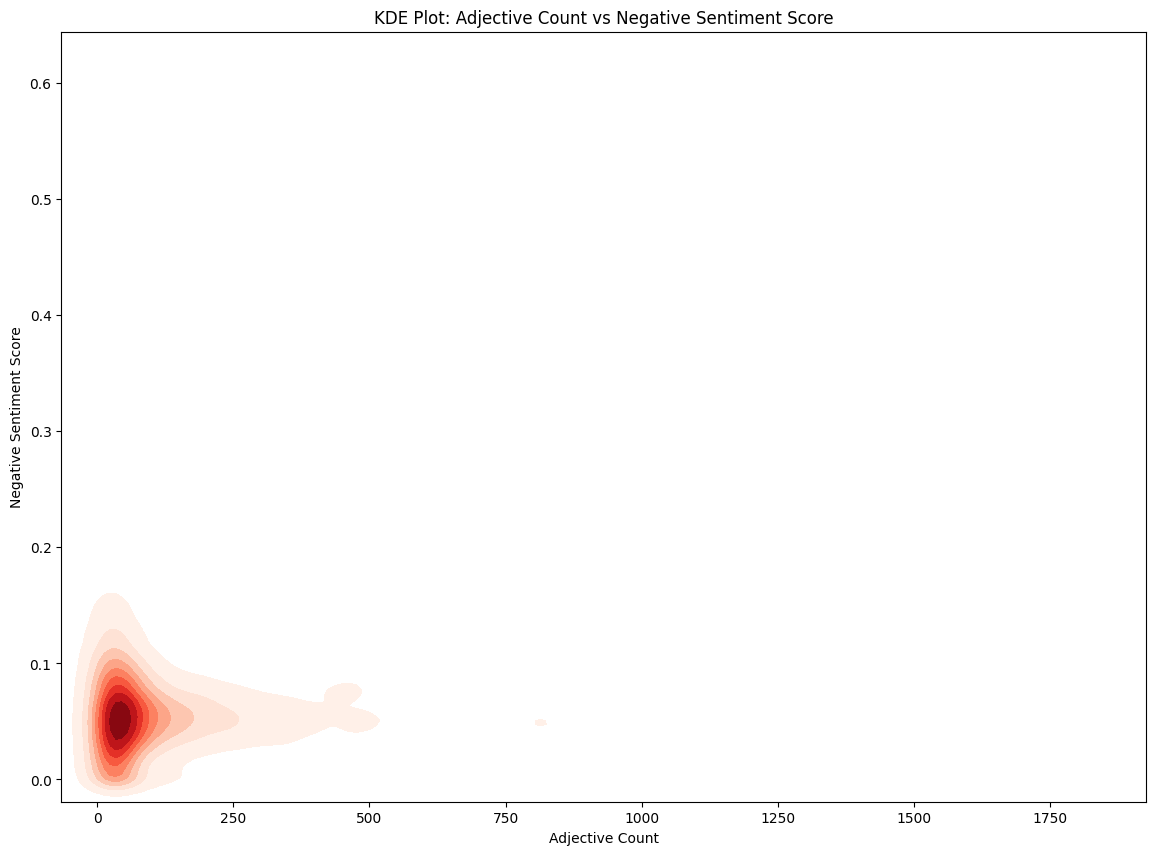

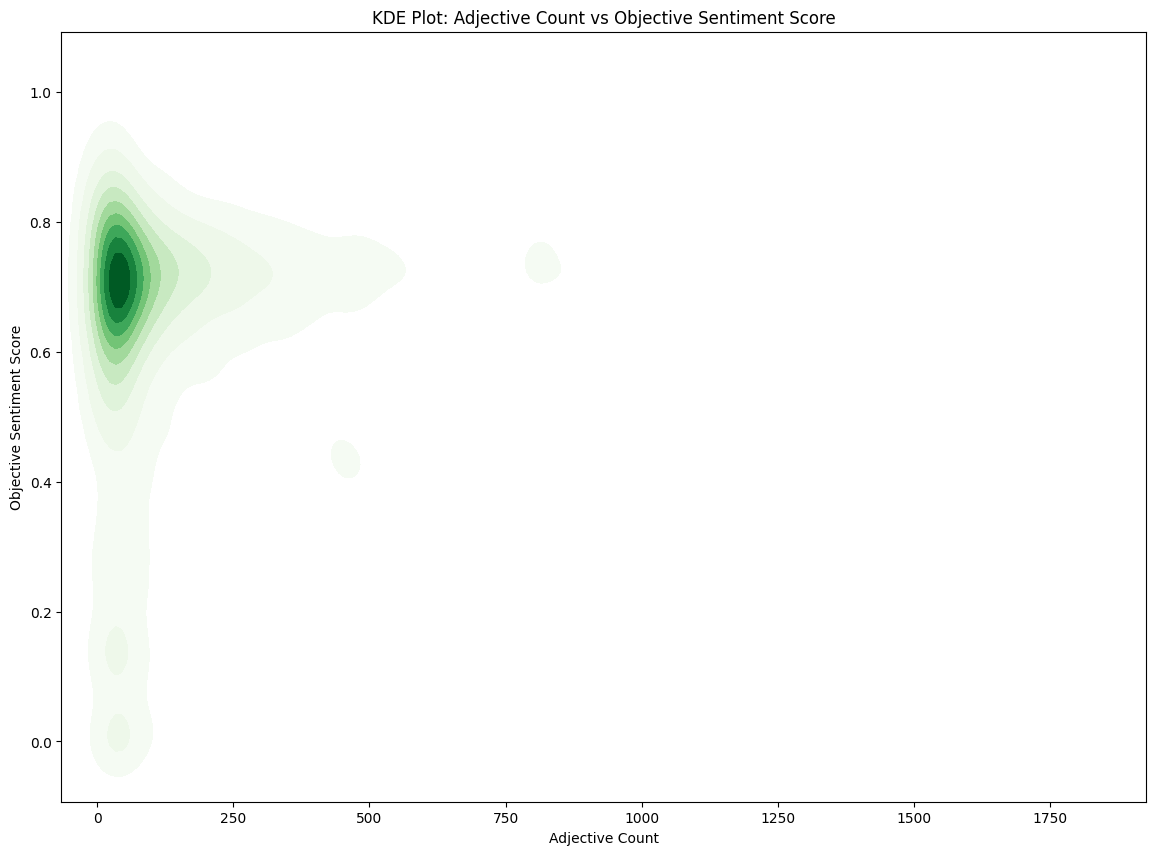

In [46]:
# Plotting KDE plots
plt.figure(figsize=(14, 10))

# KDE plot for positive sentiment score vs adjective count
sns.kdeplot(data=results_df, x='word_count', y='positive_score', fill=True, cmap="Blues", thresh=0.05)
plt.title('KDE Plot: Adjective Count vs Positive Sentiment Score')
plt.xlabel('Adjective Count')
plt.ylabel('Positive Sentiment Score')
plt.show()

# KDE plot for negative sentiment score vs adjective count
plt.figure(figsize=(14, 10))
sns.kdeplot(data=results_df, x='word_count', y='negative_score', fill=True, cmap="Reds", thresh=0.05)
plt.title('KDE Plot: Adjective Count vs Negative Sentiment Score')
plt.xlabel('Adjective Count')
plt.ylabel('Negative Sentiment Score')
plt.show()

# KDE plot for objective sentiment score vs adjective count
plt.figure(figsize=(14, 10))
sns.kdeplot(data=results_df, x='word_count', y='objective_score', fill=True, cmap="Greens", thresh=0.05)
plt.title('KDE Plot: Adjective Count vs Objective Sentiment Score')
plt.xlabel('Adjective Count')
plt.ylabel('Objective Sentiment Score')
plt.show()

In [ ]:
# next step: correlation matrix between all values. Hoewver, first I need to get the R2s.
ax1, fig =  plt.subplots(figsize= (13, 13))
sns.heatmap(abs(r2), 
            annot = True, 
            fmt=".1f"); # show numbers, but with 1 digit only